### 导入数据

In [38]:
import torch
import pandas as pd
import numpy as np
# 新数据
# 读取所有数据
paths = [
    # '../data/processed_data_900_1.csv', '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
    # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
    # '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
    # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
    # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
    # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
    # '../data/new/processed_data_1500_1.csv', '../data/new/processed_data_1500_2.csv', '../data/new/processed_data_1500_3.csv',
    # '../data/new/processed_data_1500_4.csv', '../data/new/processed_data_1500_5.csv', '../data/new/processed_data_1500_6.csv'
    '../data/clean/clean_processed_data_1500_1.csv', '../data/clean/clean_processed_data_1500_2.csv', '../data/clean/clean_processed_data_1500_3.csv',
    '../data/clean/clean_processed_data_1500_4.csv', '../data/clean/clean_processed_data_1500_5.csv', '../data/clean/clean_processed_data_1500_6.csv'
]

# 读取并拼接数据
# all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
# all_data = np.array(all_data)
# all_data.shape

In [39]:
all_data = []
for path in paths:
    data = pd.read_csv(path)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

In [40]:
all_data.shape

(2652, 1)

In [41]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data)
processed = np.array(processed)
print(processed.shape)

(2652,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_16488\2383512409.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed = np.array(processed)


### Embedding

In [6]:
import numpy as np
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [43]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
# cy_data = [[incode(value[0]) for value in row] for row in cy_data]
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_16488\161354326.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(2652,)

In [44]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (2652,)
X.shape (2652,)
y.shape (2652,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_16488\1166615506.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_16488\1166615506.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_16488\1166615506.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

### 划分训练集测试集

In [45]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (1856,)
X_test.shape (796,)
y_train.shape (1856,)
y_test.shape (796,)


In [10]:
X_train.shape

(1860,)

In [46]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (269775, 10, 4)
X_test.shape (116060, 10, 4)
y_train.shape (269775, 4)
y_test.shape (116060, 4)


In [47]:
y_train = y_train[:, :3]
y_test = y_test[:, :3]
# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
y_train.shape, y_test.shape

((269775, 3), (116060, 3))

In [13]:
y_train.shape[-1]

3

### 特征处理

In [48]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化归一化scaler 
scaler = MinMaxScaler()

# Reshape the data to 2D for fitting the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (130657*10, 4)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_scaled.reshape(X_train.shape)  # (130657, 10, 4)
X_test_normalized = X_test_scaled.reshape(X_test.shape)    # (102104, 10, 4)

y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (130657*10, 4)
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])    # (102104*10, 4)

# # y_train_reshaped = y_train.reshape(-1, 1)  # (130657*10, 4)
# # y_test_reshaped = y_test.reshape(-1, 1)    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

# Reshape back to original dimensions
y_train_normalized = y_train_scaled.reshape(y_train.shape)  # (130657, 10, 4)
y_test_normalized = y_test_scaled.reshape(y_test.shape)    # (102104, 10, 4)

X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

((269775, 10, 4), (269775, 3), (116060, 10, 4), (116060, 3))

In [49]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
# train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train))
train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))

# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))
# test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test))

### 训练

In [50]:
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
    
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)  # Use softmax for multi-class classification

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Initialize cell state
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         # Apply softmax to the output layer
#         out = self.softmax(out)
#         return out
    
# LSTM_SelfAttention model
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1)
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1)
        # output的形状是(batch_size, hidden_size)
        return output
    
# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
train epoch 0: 100%|██████████| 2108/2108 [00:20<00:00, 102.33batch/s]


Epoch 1/100, Train Loss: 0.029388432660819593, Validation Loss: 0.02200912911436688 Current learning rate: 0.0001


train epoch 1: 100%|██████████| 2108/2108 [00:21<00:00, 99.59batch/s] 


Epoch 2/100, Train Loss: 0.021915960080726816, Validation Loss: 0.020666049904515503 Current learning rate: 0.0001


train epoch 2: 100%|██████████| 2108/2108 [00:21<00:00, 96.63batch/s] 


Epoch 3/100, Train Loss: 0.020774694298629506, Validation Loss: 0.020122045422739904 Current learning rate: 0.0001


train epoch 3: 100%|██████████| 2108/2108 [00:20<00:00, 103.43batch/s]


Epoch 4/100, Train Loss: 0.02026861176509176, Validation Loss: 0.01982674989758199 Current learning rate: 0.0001


train epoch 4: 100%|██████████| 2108/2108 [00:20<00:00, 103.04batch/s]


Epoch 5/100, Train Loss: 0.020029528981616012, Validation Loss: 0.019744232108972068 Current learning rate: 0.0001


train epoch 5: 100%|██████████| 2108/2108 [00:21<00:00, 96.64batch/s]


Epoch 6/100, Train Loss: 0.01982354340783565, Validation Loss: 0.019567776682836446 Current learning rate: 0.0001


train epoch 6: 100%|██████████| 2108/2108 [00:20<00:00, 101.19batch/s]


Epoch 7/100, Train Loss: 0.019674501308433616, Validation Loss: 0.019402077051571157 Current learning rate: 0.0001


train epoch 7: 100%|██████████| 2108/2108 [00:20<00:00, 102.51batch/s]


Epoch 8/100, Train Loss: 0.019520101375218795, Validation Loss: 0.019216103841251074 Current learning rate: 0.0001


train epoch 8: 100%|██████████| 2108/2108 [00:21<00:00, 98.00batch/s] 


Epoch 9/100, Train Loss: 0.019333215248783713, Validation Loss: 0.01901352511645516 Current learning rate: 0.0001


train epoch 9: 100%|██████████| 2108/2108 [00:21<00:00, 96.87batch/s]


Epoch 10/100, Train Loss: 0.019128916638442076, Validation Loss: 0.018944790657278426 Current learning rate: 0.0001


train epoch 10: 100%|██████████| 2108/2108 [00:20<00:00, 102.82batch/s]


Epoch 11/100, Train Loss: 0.018988907574465017, Validation Loss: 0.01891939108905715 Current learning rate: 0.0001


train epoch 11: 100%|██████████| 2108/2108 [00:20<00:00, 102.17batch/s]


Epoch 12/100, Train Loss: 0.01887147948394657, Validation Loss: 0.018821126230292345 Current learning rate: 0.0001


train epoch 12: 100%|██████████| 2108/2108 [00:21<00:00, 96.32batch/s]


Epoch 13/100, Train Loss: 0.018776913855082754, Validation Loss: 0.01877448385366513 Current learning rate: 0.0001


train epoch 13: 100%|██████████| 2108/2108 [00:20<00:00, 102.60batch/s]


Epoch 14/100, Train Loss: 0.018698375761512034, Validation Loss: 0.018693737121027572 Current learning rate: 0.0001


train epoch 14: 100%|██████████| 2108/2108 [00:20<00:00, 103.92batch/s]


Epoch 15/100, Train Loss: 0.018618563892805452, Validation Loss: 0.018619182186476915 Current learning rate: 0.0001


train epoch 15: 100%|██████████| 2108/2108 [00:21<00:00, 96.75batch/s]


Epoch 16/100, Train Loss: 0.01854036871447509, Validation Loss: 0.018506665275249395 Current learning rate: 0.0001


train epoch 16: 100%|██████████| 2108/2108 [00:21<00:00, 98.98batch/s]


Epoch 17/100, Train Loss: 0.018444319431025473, Validation Loss: 0.01845096382849309 Current learning rate: 0.0001


train epoch 17: 100%|██████████| 2108/2108 [00:20<00:00, 103.14batch/s]


Epoch 18/100, Train Loss: 0.018400824776270717, Validation Loss: 0.018350911809647093 Current learning rate: 0.0001


train epoch 18: 100%|██████████| 2108/2108 [00:21<00:00, 99.59batch/s] 


Epoch 19/100, Train Loss: 0.018322574798085335, Validation Loss: 0.018228586340367885 Current learning rate: 0.0001


train epoch 19: 100%|██████████| 2108/2108 [00:21<00:00, 96.43batch/s]


Epoch 20/100, Train Loss: 0.018259633859065916, Validation Loss: 0.018190830422308252 Current learning rate: 0.0001


train epoch 20: 100%|██████████| 2108/2108 [00:20<00:00, 102.80batch/s]


Epoch 21/100, Train Loss: 0.01821893851445866, Validation Loss: 0.018104360537209006 Current learning rate: 0.0001


train epoch 21: 100%|██████████| 2108/2108 [00:20<00:00, 102.89batch/s]


Epoch 22/100, Train Loss: 0.01815916973906631, Validation Loss: 0.018057491914503294 Current learning rate: 0.0001


train epoch 22: 100%|██████████| 2108/2108 [00:21<00:00, 97.23batch/s] 


Epoch 23/100, Train Loss: 0.018111994544376207, Validation Loss: 0.018030166994459293 Current learning rate: 0.0001


train epoch 23: 100%|██████████| 2108/2108 [00:20<00:00, 101.85batch/s]


Epoch 24/100, Train Loss: 0.018071771816126195, Validation Loss: 0.017975224568967104 Current learning rate: 0.0001


train epoch 24: 100%|██████████| 2108/2108 [00:20<00:00, 101.94batch/s]


Epoch 25/100, Train Loss: 0.01803112142299256, Validation Loss: 0.01797578221551772 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


train epoch 25: 100%|██████████| 2108/2108 [00:21<00:00, 97.64batch/s] 


Epoch 26/100, Train Loss: 0.017997832439315308, Validation Loss: 0.01795466087215676 Current learning rate: 0.0001


train epoch 26: 100%|██████████| 2108/2108 [00:21<00:00, 97.22batch/s]


Epoch 27/100, Train Loss: 0.017965667229383236, Validation Loss: 0.017913296248392798 Current learning rate: 0.0001


train epoch 27: 100%|██████████| 2108/2108 [00:20<00:00, 102.25batch/s]


Epoch 28/100, Train Loss: 0.017938667968368606, Validation Loss: 0.017920780926349196 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


train epoch 28: 100%|██████████| 2108/2108 [00:20<00:00, 102.34batch/s]


Epoch 29/100, Train Loss: 0.017909636444998003, Validation Loss: 0.017912740191827436 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


train epoch 29: 100%|██████████| 2108/2108 [00:21<00:00, 96.78batch/s]


Epoch 30/100, Train Loss: 0.017874025333290546, Validation Loss: 0.0178929438565582 Current learning rate: 0.0001


train epoch 30: 100%|██████████| 2108/2108 [00:20<00:00, 103.63batch/s]


Epoch 31/100, Train Loss: 0.01784532154163811, Validation Loss: 0.017853458531567588 Current learning rate: 0.0001


train epoch 31: 100%|██████████| 2108/2108 [00:20<00:00, 102.79batch/s]


Epoch 32/100, Train Loss: 0.017826043635955403, Validation Loss: 0.01790538052631036 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


train epoch 32: 100%|██████████| 2108/2108 [00:21<00:00, 96.91batch/s]


Epoch 33/100, Train Loss: 0.01779207988713452, Validation Loss: 0.017885160687318057 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


train epoch 33: 100%|██████████| 2108/2108 [00:20<00:00, 100.60batch/s]


Epoch 34/100, Train Loss: 0.017766065176549203, Validation Loss: 0.017822940266197507 Current learning rate: 0.0001


train epoch 34: 100%|██████████| 2108/2108 [00:20<00:00, 102.69batch/s]


Epoch 35/100, Train Loss: 0.017747365741355027, Validation Loss: 0.017819663510127624 Current learning rate: 0.0001


train epoch 35: 100%|██████████| 2108/2108 [00:21<00:00, 98.42batch/s] 


Epoch 36/100, Train Loss: 0.017720958557387402, Validation Loss: 0.017840291613129163 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


train epoch 36: 100%|██████████| 2108/2108 [00:21<00:00, 97.07batch/s]


Epoch 37/100, Train Loss: 0.017693912711612345, Validation Loss: 0.017816326693907536 Current learning rate: 0.0001


train epoch 37: 100%|██████████| 2108/2108 [00:20<00:00, 102.35batch/s]


Epoch 38/100, Train Loss: 0.017659379629835704, Validation Loss: 0.01780946667083049 Current learning rate: 0.0001


train epoch 38: 100%|██████████| 2108/2108 [00:20<00:00, 102.64batch/s]


Epoch 39/100, Train Loss: 0.017635547118286583, Validation Loss: 0.017802162277570654 Current learning rate: 0.0001


train epoch 39: 100%|██████████| 2108/2108 [00:21<00:00, 96.39batch/s] 


Epoch 40/100, Train Loss: 0.01762117567311854, Validation Loss: 0.017778563295650068 Current learning rate: 0.0001


train epoch 40: 100%|██████████| 2108/2108 [00:20<00:00, 102.40batch/s]


Epoch 41/100, Train Loss: 0.017598007977890302, Validation Loss: 0.017779128927945212 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


train epoch 41: 100%|██████████| 2108/2108 [00:20<00:00, 103.75batch/s]


Epoch 42/100, Train Loss: 0.017563865775053384, Validation Loss: 0.017766079445235543 Current learning rate: 0.0001


train epoch 42: 100%|██████████| 2108/2108 [00:21<00:00, 96.68batch/s] 


Epoch 43/100, Train Loss: 0.01753962354898449, Validation Loss: 0.017760456325494965 Current learning rate: 0.0001


train epoch 43: 100%|██████████| 2108/2108 [00:21<00:00, 99.47batch/s] 


Epoch 44/100, Train Loss: 0.017512439077412605, Validation Loss: 0.017761033673501764 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


train epoch 44: 100%|██████████| 2108/2108 [00:20<00:00, 103.74batch/s]


Epoch 45/100, Train Loss: 0.01750928127629461, Validation Loss: 0.017779399231752015 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


train epoch 45: 100%|██████████| 2108/2108 [00:21<00:00, 99.48batch/s] 


Epoch 46/100, Train Loss: 0.017471616199941094, Validation Loss: 0.017794494838653415 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


train epoch 46: 100%|██████████| 2108/2108 [00:21<00:00, 97.12batch/s]


Epoch 47/100, Train Loss: 0.017452209031531756, Validation Loss: 0.01779417140445642 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


train epoch 47: 100%|██████████| 2108/2108 [00:20<00:00, 103.08batch/s]


Epoch 48/100, Train Loss: 0.017412222592942568, Validation Loss: 0.017809304890755252 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


train epoch 48: 100%|██████████| 2108/2108 [00:20<00:00, 102.54batch/s]


Epoch 49/100, Train Loss: 0.017393339980234516, Validation Loss: 0.017847993837918432 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


train epoch 49: 100%|██████████| 2108/2108 [00:21<00:00, 96.92batch/s]


Epoch 50/100, Train Loss: 0.017355434785288896, Validation Loss: 0.01785424136947164 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


train epoch 50: 100%|██████████| 2108/2108 [00:20<00:00, 102.18batch/s]


Epoch 51/100, Train Loss: 0.01733305446230785, Validation Loss: 0.017896975872390572 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


train epoch 51: 100%|██████████| 2108/2108 [00:20<00:00, 102.18batch/s]


Epoch 52/100, Train Loss: 0.017316023687425405, Validation Loss: 0.017859541541517674 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


train epoch 52: 100%|██████████| 2108/2108 [00:21<00:00, 97.32batch/s] 


Epoch 53/100, Train Loss: 0.017273874380269442, Validation Loss: 0.01793163631106185 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


train epoch 53: 100%|██████████| 2108/2108 [00:21<00:00, 98.68batch/s] 


Epoch 54/100, Train Loss: 0.0172467812873802, Validation Loss: 0.017899649659913704 Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


train epoch 54: 100%|██████████| 2108/2108 [00:20<00:00, 102.28batch/s]


Epoch 55/100, Train Loss: 0.017196640922453293, Validation Loss: 0.0179340152380442 Current learning rate: 0.0001
EarlyStopping counter: 19 out of 20


train epoch 55: 100%|██████████| 2108/2108 [00:20<00:00, 101.13batch/s]


Epoch 56/100, Train Loss: 0.01715842472253955, Validation Loss: 0.017915832736189147 Current learning rate: 0.0001
EarlyStopping counter: 20 out of 20
Early stopping


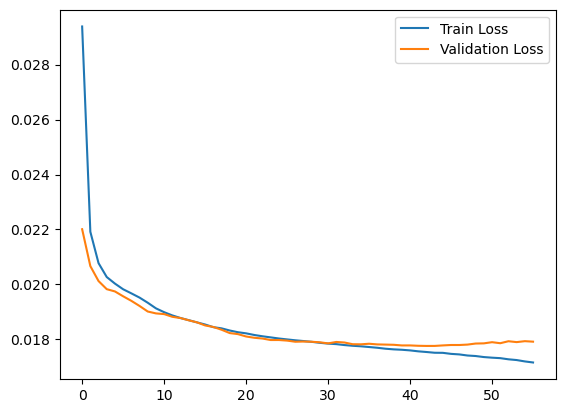

Epoch 56/100, Train Loss: 0.01715842472253955, Validation Loss: 0.017915832736189147
Test RMSE: 0.13327673
CPU times: total: 1min 16s
Wall time: 23min 38s


In [51]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 256
num_layers = 2
batch_size = 128
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
 

# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 4
num_classes= 3

# model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3, num_heads=8)
# print('num_classes:', num_classes)

model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=3, min_lr=1e-6, verbose=True)

# 训练模型
num_epochs = 100
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if val_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

# 保存最好的模型
torch.save(best_model, '../model/mul256_l2_T1500c_s2s.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, num_classes)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

### Evaluation

In [127]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

In [54]:
# 数据转回原始尺度
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)


In [92]:
predictions.shape, targets.shape

((264803, 3), (264803, 3))

In [57]:
predictions_s = predictions
targets_s = targets
predictions = predictions[:, :-1]
targets = targets[:, :-1]

predictions.shape, targets.shape

((264803, 3), (264803, 3))

#### 指标

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
# pre_round = np.round(new_pred)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, predictions)
print("R^2 Score:", r2)

Test RMSE: 0.6262816
Mean Squared Error (MSE): 0.3922287
Mean Absolute Error (MAE): 0.2960807
R^2 Score: 0.5503627578655078


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 四舍五入的
pre_round = np.round(predictions)
print('Test RMSE:', np.sqrt(mean_squared_error(targets, pre_round)))
# 计算均方误差（MSE）
mse = mean_squared_error(targets, pre_round)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差（MAE）
mae = mean_absolute_error(targets, pre_round)
print("Mean Absolute Error (MAE):", mae)

# 计算R平方
r2 = r2_score(targets, pre_round)
print("R^2 Score:", r2)

Test RMSE: 0.6482256
Mean Squared Error (MSE): 0.42019644
Mean Absolute Error (MAE): 0.23850882
R^2 Score: 0.4396946465779387


In [59]:
#保存预测结果
np.savez('../results/mul256_l2_T1500c_s2s.npz', arr1=targets, arr2=predictions)

In [36]:
import numpy as np
# 读取预测结果
data = np.load('../results/mul_T1500_ss_t.npz')
targets = data['arr1']
predictions = data['arr2']

In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

In [30]:
target[1]

array([1., 0., 3.], dtype=float32)

#### 画图

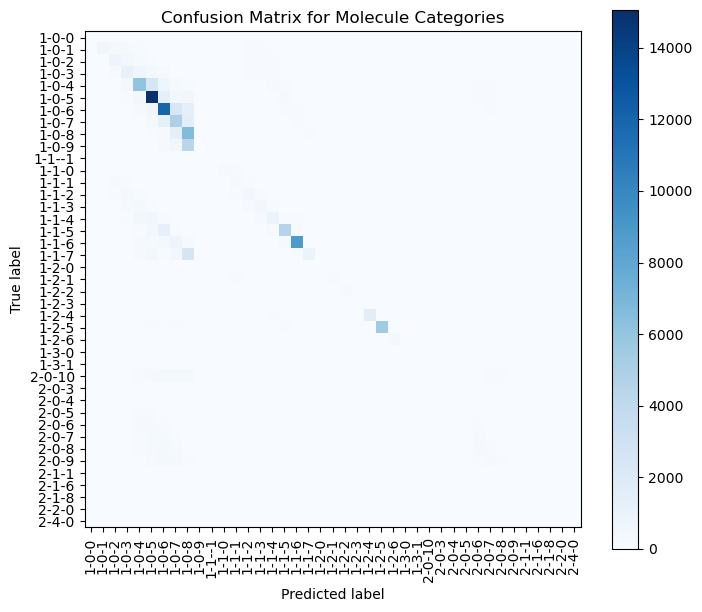

Accuracy: 0.6105687624397935


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
start = 0
end = -1
p_round = np.round(predictions).astype(int)
t_round = np.round(targets).astype(int)
p1 = p_round[start:end]
t1 = t_round[start:end]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 将每个向量转换为字符串形式，便于分类
target_str = ["-".join(map(str, x)) for x in t1]
prediction_str = ["-".join(map(str, x)) for x in p1]

# 找到所有唯一的类别
all_classes = sorted(set(target_str + prediction_str))
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}

# 将类别字符串映射到索引
target_indices = [class_to_index[cls] for cls in target_str]
prediction_indices = [class_to_index[cls] for cls in prediction_str]

# # 计算混淆矩阵
cm = confusion_matrix(target_indices, prediction_indices, labels=range(len(all_classes)))

# # 绘制混淆矩阵
# fig, ax = plt.subplots(figsize=(20, 18))  # 设置更大的图像尺寸
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)  # 传递 ax
# plt.title("Confusion Matrix for Molecule Categories")
# plt.show()

# plt.figure(figsize=(20, 18))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title("Confusion Matrix for molecule Categories")
# plt.show()

# 生成混淆矩阵可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
fig, ax = plt.subplots(figsize=(8, 7))
# fig, ax = plt.subplots(figsize=(18, 17))
# 只绘制色块，不显示文本
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
for text in ax.texts:
    text.set_visible(False)  # 隐藏所有文本

plt.title("Confusion Matrix for Molecule Categories")
plt.show()

# 计算混淆矩阵
# conf_matrix = confusion_matrix(target_indices, prediction_indices)

# 可视化混淆矩阵
# conf_df = pd.DataFrame(cm, index=range(33), columns=range(33))
# plt.figure(figsize=(8, 7))
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.imshow(conf_df, cmap='coolwarm', interpolation='nearest')
# plt.colorbar()
# plt.show()

# 计算准确率
accuracy = accuracy_score(target_indices, prediction_indices)

# 打印评估指标
print(f'Accuracy: {accuracy}')

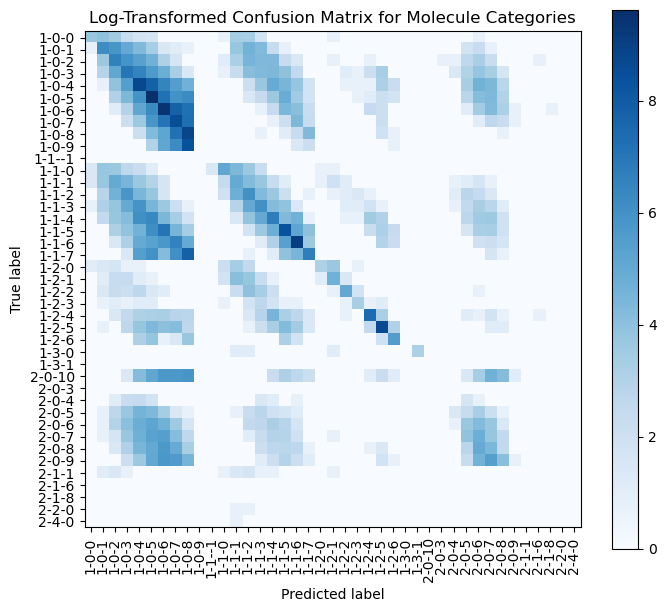

In [60]:
# 对混淆矩阵进行对数变换 (log1p 避免 log(0) 问题)
log_cm = np.log(cm+1)  # log1p(x) = log(1 + x)，适用于数据有0的情况
# 显示转换后的混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=all_classes)
fig, ax = plt.subplots(figsize=(8, 7))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

# 隐藏文本
for text in ax.texts:
    text.set_visible(False)

plt.title("Log-Transformed Confusion Matrix for Molecule Categories")
plt.show()


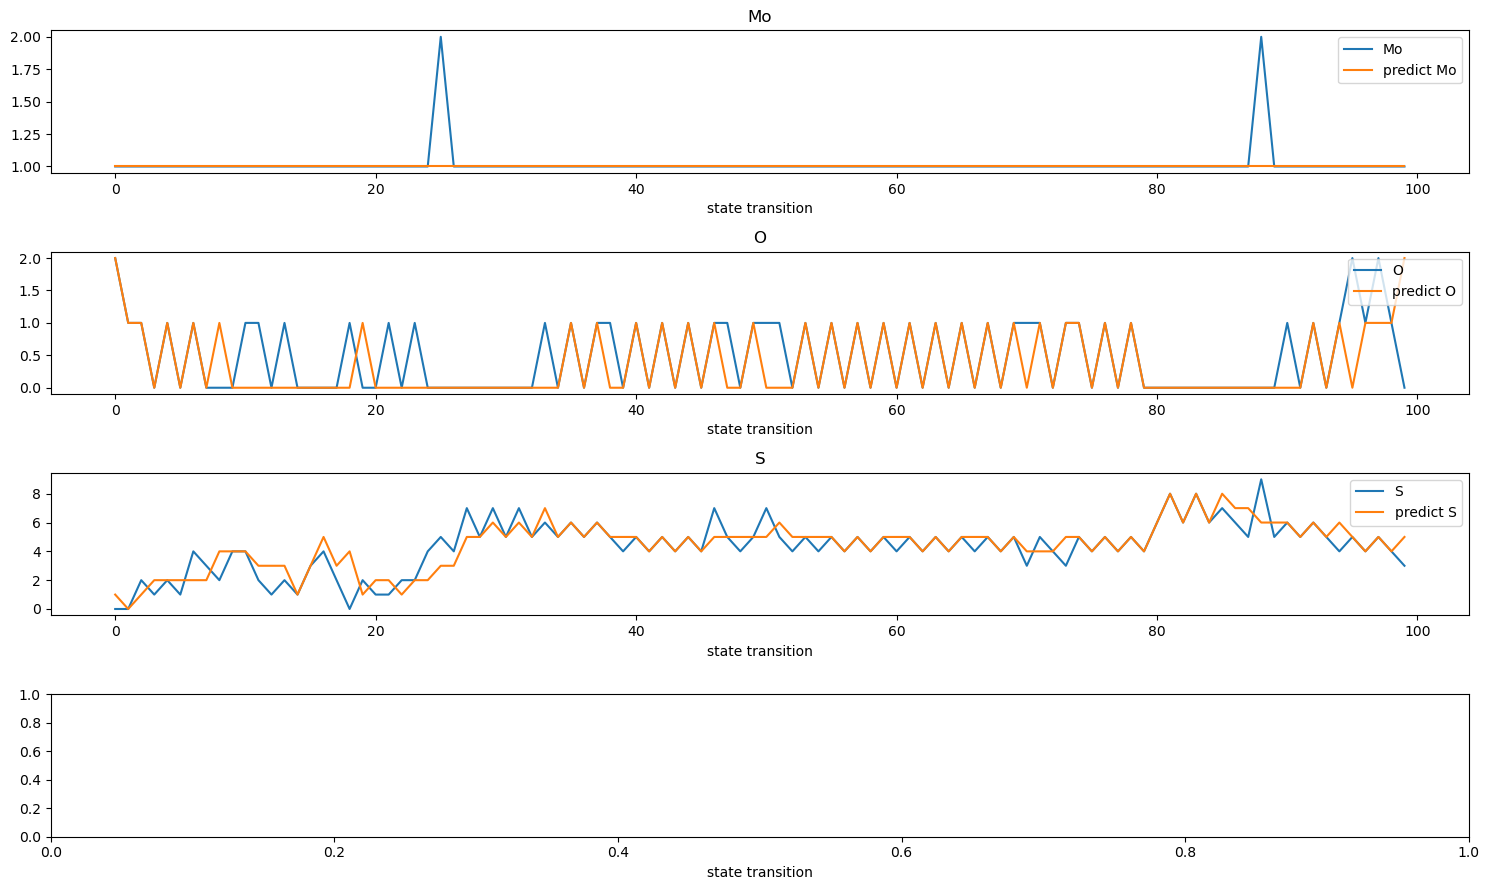

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end]
t1 = t_round[start:end]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

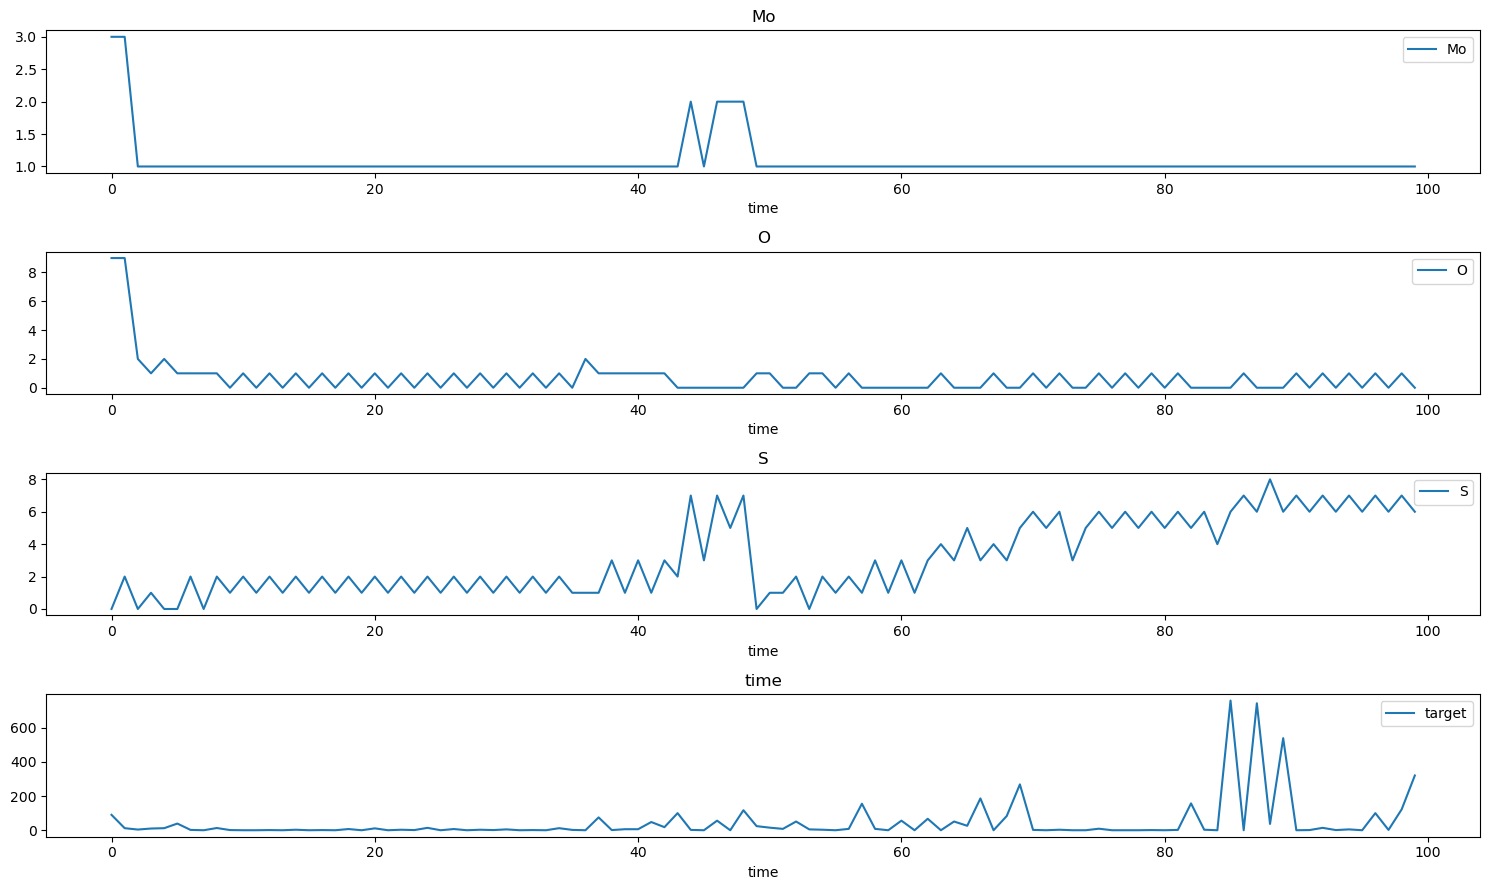

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [1]:
import numpy as np
ss = np.load('../results/mul_T900_ss.npz')
ss_targets = ss['arr1']
ss_predictions = ss['arr2']

sts = np.load('../results/mul_T900_sts.npz')
sts_targets = sts['arr1']
sts_predictions = sts['arr2']

stst = np.load('../results/mul_T900_stst.npz')
stst_targets = stst['arr1']
stst_predictions = stst['arr2']

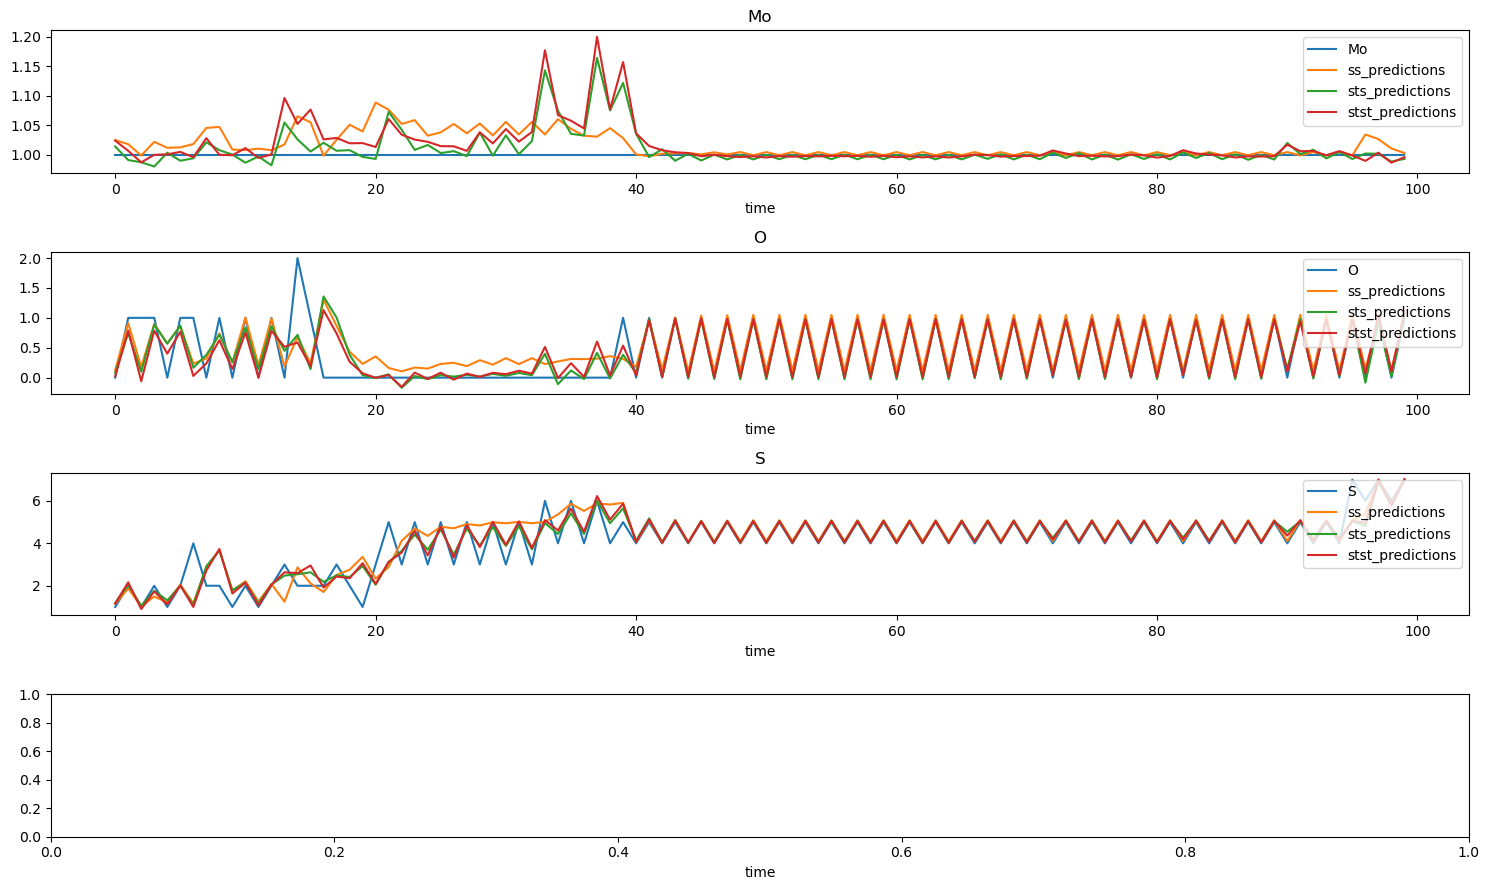

In [3]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = stst_targets #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(ss_predictions[start:end, 0], label='ss_predictions')
axs[0].plot(sts_predictions[start:end, 0], label='sts_predictions')
axs[0].plot(stst_predictions[start:end, 0], label='stst_predictions')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(ss_predictions[start:end, 1], label='ss_predictions')
axs[1].plot(sts_predictions[start:end, 1], label='sts_predictions')
axs[1].plot(stst_predictions[start:end, 1], label='stst_predictions')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(ss_predictions[start:end, 2], label='ss_predictions')
axs[2].plot(sts_predictions[start:end, 2], label='sts_predictions')
axs[2].plot(stst_predictions[start:end, 2], label='stst_predictions')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
# axs[3].plot(t1[:, 3], label='target')
# # axs[3].plot(p1[:, 3], label='predict')
# axs[3].set_title('time')
# axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')